### Implementing XGBoost in Python


#### Steps and Notes for XGBoost
+ **Step 1**: Start with initial prediction. The default is 0.5 for classification and regression.
+ **Step 2**: Build a tree just like we do for XGBoost for regression. The root node starts with all the residuals in it.
+ **Step 3**: Calculate the similarity score of the leaf node. The similarity score is (sum of residuals)^2 / Sum[(Prev Prob.i * (1- Prev Prob.i)] + regularization term)
+ **Step 4**: Cluster similar residuals by splitting the tree. For each potential split, send the residuals down the tree into the potential left and right leaf nodes. Then, calculate the similarity score for the left and right leaves by plugging in the given leaf to the formula. Higher similarity means similar residuals.
+ **Step 5**: Calculate the gain just like we do for regression XGBoost. Gain = Left similarity + Right similarity - Root similarity. The highest gain is the best split. Keep building the tree as long as cover is not less than the predetermined threshold. (min_child_weight). The formula for cover is Sum[Prev Prob.i * (1 - Prev Prob.i)]
+ **Step 6**: Prune if needed. If Gain-Gamma is positive do not prune.
+ **Step 7**: Determine the output of the leaves. Output = Sum(residuals in the leaf) / Sum[Prev Prob.i * (1 - Prev Prob.i)] + regularization term.
+ Step 8**: Convert initial probability to log odds. Then, add this log odds to the output of the current tree * learning rate. The default learning rate is 0.3.
+ **Step 9**: Convert back to probability using e^log odds / (1 + e^log odds).
+ XGBoost cannot handle object datatypes. Convert to boolean or OneHotEncode them.
+ When using dataviz to draw the tree we cannot have whitespaces so convert them to underscores.

In [93]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [65]:
# configure pandas to see all columns
pd.set_option('display.max_columns', None)

In [66]:
# import data
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

In [67]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [68]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Now we can get a look at our columns. For each column we will print the column name followed by the length of the unique values and the unique values themselves. This tells us what variables are boolean.

In [70]:
for col in df.columns:
    print(col, len(df[col].unique()), df[col].unique())

customerID 7043 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender 2 ['Female' 'Male']
SeniorCitizen 2 [0 1]
Partner 2 ['Yes' 'No']
Dependents 2 ['No' 'Yes']
tenure 73 [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService 2 ['No' 'Yes']
MultipleLines 3 ['No phone service' 'No' 'Yes']
InternetService 3 ['DSL' 'Fiber optic' 'No']
OnlineSecurity 3 ['No' 'Yes' 'No internet service']
OnlineBackup 3 ['Yes' 'No' 'No internet service']
DeviceProtection 3 ['No' 'Yes' 'No internet service']
TechSupport 3 ['No' 'Yes' 'No internet service']
StreamingTV 3 ['No' 'Yes' 'No internet service']
StreamingMovies 3 ['No' 'Yes' 'No internet service']
Contract 3 ['Month-to-month' 'One year' 'Two year']
PaperlessBilling 2 ['Yes' 'No']
PaymentMethod 4 ['Electronic check' 'Mailed check' 'Ban

In [71]:
df.drop('customerID', axis=1, inplace=True)

In [72]:
# total charges should be numeric but has an empty string so we cant do it easily.
df.loc[df['TotalCharges'] == ' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [73]:
# replace the empty space with a 0
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)

In [74]:
# make sure these are the same 11 we had previously
df.loc[df['TotalCharges'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No


In [75]:
# now convert the column to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [76]:
# make sure there is no whitespaces in any columns so that we can draw the tree
df.replace(' ', '_', regex=True, inplace=True)

##### Split the Data

In [77]:
# replace the Churn target variable with 1 for Churn and 0 for no Churn
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

C:\Users\ryans\AppData\Local\Temp\ipykernel_44816\1736284044.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


In [78]:
# create X and y splits
X = df.drop('Churn', axis = 1).copy()
y = df['Churn'].copy()

In [79]:
# encode the categorical data using pd.get_dummies()
X_encoded = pd.get_dummies(X)

In [80]:
X_encoded

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,False,True,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,False,True,False,True,False,True,False,True,False,False,True,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True
7039,0,72,103.20,7362.90,True,False,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False,False
7040,0,11,29.60,346.45,True,False,False,True,False,True,True,False,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
7041,1,4,74.40,306.60,False,True,False,True,True,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True


##### Check the Balance of the Data

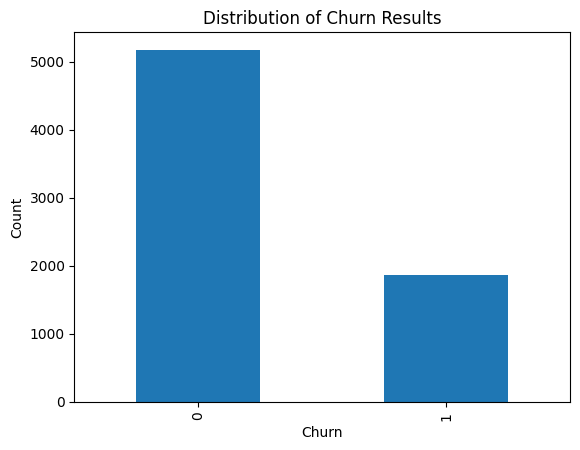

In [81]:
import matplotlib.pyplot as plt

# create counts for each
churn_counts = df['Churn'].value_counts()

# create plot
fig, ax = plt.subplots()
churn_counts.plot(kind='bar', ax=ax)
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
ax.set_title('Distribution of Churn Results')
plt.show()


In [82]:
# how imbalanced is it
counts = df['Churn'].value_counts(normalize=True)
counts

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [83]:
# stratify split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)


In [84]:
y_train.value_counts(normalize=True)

Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

In [85]:
y_test.value_counts(normalize=True)

Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64

In [94]:
# build the first model
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
# Fit the model with early stopping 

# Build the first model with eval_metric as a parameter 
clf_xgb = XGBClassifier(objective='binary:logistic', missing=None, seed=42,) 
clf_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='aucpr', early_stopping_rounds=10, verbose=True)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'eval_metric'

In [62]:
# Build the model 
clf_xgb = XGBClassifier(objective='binary:logistic', seed=42, eval_metric='aucpr') 


In [63]:
clf_xgb.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)